In [10]:
import os
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
import plotly.graph_objs as go
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
gc.collect()
plt.rcParams['figure.figsize'] = [20, 8]

In [11]:
train = pd.read_csv('../input/X_train.csv')
y = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [12]:
tmp = dict(zip(y.series_id, y.surface))
train['target'] = train['series_id'].map(tmp)
train.head()
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,target
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,fine_concrete


In [13]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,target
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,fine_concrete


In [14]:
le = LabelBinarizer()
lb = LabelEncoder()
target = le.fit_transform(y['surface'])
target = np.array(target)
y['s']=lb.fit_transform(y['surface'])

In [15]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def elr(train):
    x, y, z, w = train['orientation_X'].tolist(), train['orientation_Y'].tolist(), train['orientation_Z'].tolist(), train['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    train['euler_x'] = nx
    train['euler_y'] = ny
    train['euler_z'] = nz
    return(train)    

train = elr(train)
test = elr(test)
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,target,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,fine_concrete,2.843272,-0.024668,1.396664
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,fine_concrete,2.843199,-0.024662,1.396646
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,fine_concrete,2.843224,-0.024728,1.396682
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,fine_concrete,2.843186,-0.024770,1.396721
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,fine_concrete,2.843195,-0.024784,1.396693


In [16]:
def create_seg(train):
    segments = []

    for i in range(0, len(train), 128): 
        ox = train.orientation_X.values[i:i+128]
        oy = train.orientation_Y.values[i:i+128]
        oz = train.orientation_Z.values[i:i+128]
        ow = train.orientation_W.values[i:i+128]
        ax = train.angular_velocity_X.values[i:i+128]
        ay = train.angular_velocity_Y.values[i:i+128]
        az = train.angular_velocity_Z.values[i:i+128]
        lx = train.linear_acceleration_X.values[i:i+128]
        ly = train.linear_acceleration_Y.values[i:i+128]
        lz = train.linear_acceleration_Z.values[i:i+128]
        ex = train.euler_x.values[i:i+128]
        ey = train.euler_y.values[i:i+128]
        ez = train.euler_z.values[i:i+128]

        segments.append([ox, oy, oz, ow, ax, ay,az,lx, ly, lz, ex, ey, ez])
    segments = np.asarray(segments, dtype= np.float32).reshape(-1, 128, 13)
    return segments

In [17]:
seg = create_seg(train)
test = create_seg(test)

In [18]:
model = Sequential()
model.add(Conv1D(128, 1, input_shape = (128,13)))
model.add(Activation("relu"))
model.add(Conv1D(128,1))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Conv1D(64,3))
model.add(Activation("relu"))
model.add(Conv1D(64,3))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Conv1D(32,5))
model.add(Activation("relu"))
model.add(Conv1D(32,5))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(9, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 128)          1792      
_________________________________________________________________
activation_3 (Activation)    (None, 128, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 128)          16512     
_________________________________________________________________
activation_4 (Activation)    (None, 128, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 64)            24640     
__________

In [20]:
filepath = "skynet.hdf5"
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), 
                 keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model.fit(seg,
                      target,
                      batch_size=50,
                      epochs=100,
                      callbacks=callbacks_list,
                      validation_split=0.3,
                      shuffle=True,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2667 samples, validate on 1143 samples
Epoch 1/100
2667/2667 [==============================] - 4s 1ms/step - loss: 2.0268 - acc: 0.2070 - val_loss: 1.9237 - val_acc: 0.2441

Epoch 00001: val_loss improved from inf to 1.92365, saving model to skynet.hdf5
Epoch 2/100
2667/2667 [==============================] - 3s 958us/step - loss: 1.8594 - acc: 0.2441 - val_loss: 1.7681 - val_acc: 0.3010

Epoch 00002: val_loss improved from 1.92365 to 1.76805, saving model to skynet.hdf5
Epoch 3/100
2667/2667 [==============================] - 3s 948us/step - loss: 1.6909 - acc: 0.3352 - val_loss: 1.5975 - val_acc: 0.3106

Epoch 00003: val_loss improved from 1.76805 to 1.59752, saving model to skynet.hdf5
Epoch 4/100
2667/2667 [==============================] - 3s 955us/step - loss: 1.5309 - acc: 0.4353 - val_loss: 1.6428 - val_acc: 0.3211

Epoch 00004: val_loss did not improve from 1.59752
Epoch 5/100
2667/2667 [==============================] 

2667/2667 [==============================] - 3s 963us/step - loss: 0.5061 - acc: 0.8185 - val_loss: 0.9238 - val_acc: 0.6868

Epoch 00039: val_loss did not improve from 0.81888
Epoch 40/100
2667/2667 [==============================] - 3s 945us/step - loss: 0.4958 - acc: 0.8286 - val_loss: 0.7625 - val_acc: 0.7419

Epoch 00040: val_loss improved from 0.81888 to 0.76249, saving model to skynet.hdf5
Epoch 41/100
2667/2667 [==============================] - 3s 953us/step - loss: 0.4802 - acc: 0.8286 - val_loss: 0.8634 - val_acc: 0.6938

Epoch 00041: val_loss did not improve from 0.76249
Epoch 42/100
2667/2667 [==============================] - 3s 948us/step - loss: 0.4750 - acc: 0.8305 - val_loss: 0.7946 - val_acc: 0.7218

Epoch 00042: val_loss did not improve from 0.76249
Epoch 43/100
2667/2667 [==============================] - 3s 950us/step - loss: 0.4541 - acc: 0.8313 - val_loss: 0.9491 - val_acc: 0.6807

Epoch 00043: val_loss did not improve from 0.76249
Epoch 44/100
2667/2667 [======

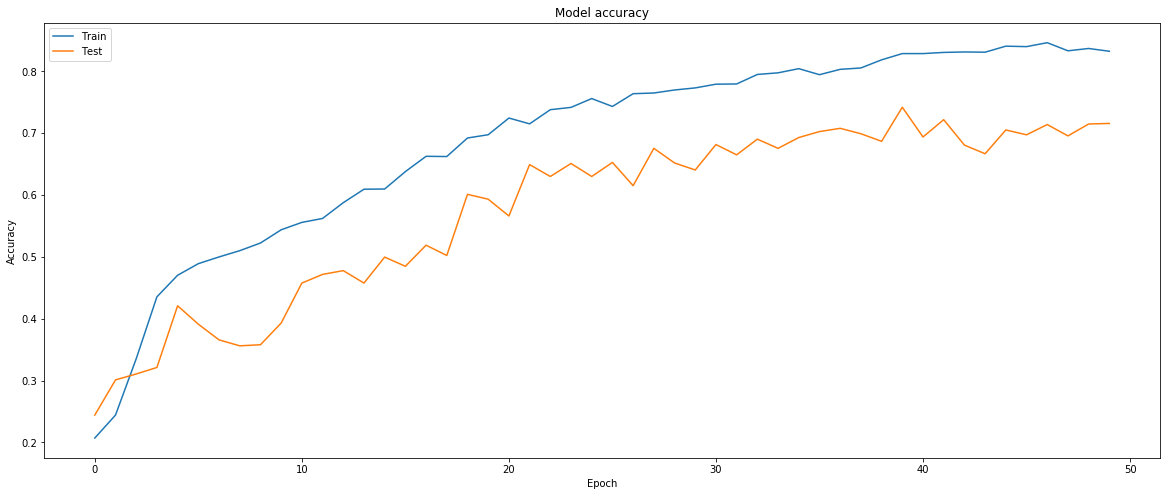

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

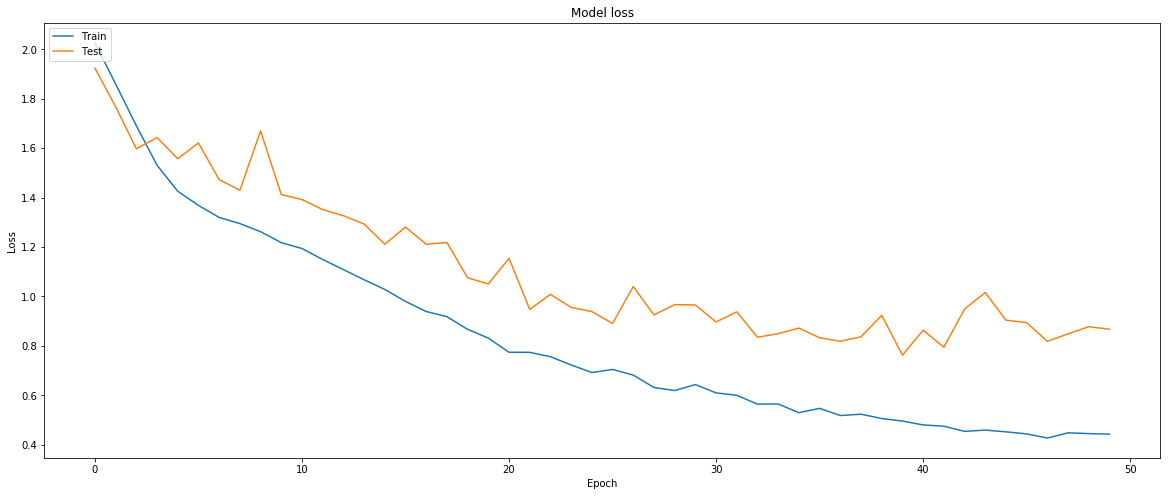

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
model.load_weights(filepath)
predictions = model.predict(test)
prd = le.inverse_transform(predictions)
ss['surface'] = prd
ss.to_csv('submission.csv', index=False)